Picking the top machine learning model is complex; try different algorithms and test efficacy with k-fold cross-validation. Train backup algorithm with multiple models to use as alternative. Utilize all models in group, not just the best. "Super learner" tests, educates and optimizes algorithms using various factors like covariates, loss functions, and tuning parameters. The model uses the super learner technique with 50 base-models and a linear meta-model for stacked generalization, resulting in a 1K x 50 input data. No overfitting. Super learner measures predictability and blends models with a meta-model. Test new data with regression and enhance predictions through training base-models on entire dataset for future use, if necessary for the super learner. Collect sample, merge results, apply meta-model. Steps: Acquire sample. Simplify models and merge predictions for meta-model predictions using a super learner algorithm.

# **Super Learner for Regression**: 

Using make_regression() to generate 1,000 rows with 100 columns for a simple regression problem with added noise. Data split for training and evaluation: 50% used for training, 50% held for final super model and base-models.

We'll use k-fold cross-validation to make out-of-fold predictions for the super learner. This means splitting the data into 10 folds and fitting the model on the training part while predicting on the test part of each fold. This is done for each model, with all out-of-fold predictions saved as columns for the meta-model input. We'll combine algorithm columns horizontally for one fold of data, then vertically stack the groups into a single dataset with 500 rows and 9 columns. Function get_out_of_fold_predictions() returns the required input and output dataset for training the meta-model with a test dataset and model list.

# **Imports**

In [1]:
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, concatenate
from pandas import DataFrame, read_csv
from os import makedirs
from matplotlib import pyplot
from mlens.ensemble import SuperLearner
from math import sqrt
from numpy import hstack, vstack, asarray, mean, std, array, argmax, dstack, sum, number
from sklearn.datasets import make_regression, make_blobs
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

[MLENS] backend: threading


# **Super Learner for Regression**

In [2]:
def return_models_regression():
 return [LinearRegression(),ElasticNet(),SVR(gamma='scale'),DecisionTreeRegressor(),KNeighborsRegressor(),AdaBoostRegressor(),
           BaggingRegressor(n_estimators=10),RandomForestRegressor(n_estimators=10),ExtraTreesRegressor(n_estimators=10)]
 
def return_out_of_fold_pred(X, y, models):
 X_meta, y_meta = list(), list()
 kfold = KFold(n_splits=10, shuffle=True)
 for train_ix, test_ix in kfold.split(X):
    fold_yhats = list()
    train_X, test_X, train_y, test_y = X[train_ix], X[test_ix], y[train_ix], y[test_ix]
    y_meta.extend(test_y)
    for model in models:
        model.fit(train_X, train_y)
        yhat = model.predict(test_X)
        fold_yhats.append(yhat.reshape(len(yhat),1))
    X_meta.append(hstack(fold_yhats))
 return vstack(X_meta), asarray(y_meta)
 
def fit_base_models(X, y, models):
 for model in models: model.fit(X, y)
 
def fit_meta_model_regression(X, y):
  model = LinearRegression()
  model.fit(X, y)
  return model
 
def evaluate_models_regression(X, y, models):
 for model in models:
    yhat = model.predict(X)
    mse = mean_squared_error(y, yhat)
    print('%s: RMSE %.3f' % (model.__class__.__name__, sqrt(mse)))
 
def super_learner_predictions(X, models, meta_model):
 X_meta = list()
 for model in models:
    yhat = model.predict(X)
    X_meta.append(yhat.reshape(len(yhat),1))
 X_meta = hstack(X_meta)
 return meta_model.predict(X_meta)
 
X,y = make_regression(n_samples=1000, n_features=100, noise=0.5)
X, X_val, y, y_val = train_test_split(X,y, test_size=0.50)
print('Training shape', X.shape, y.shape, 'Testing shape', X_val.shape, y_val.shape)
models = return_models_regression()
X_meta, y_meta = return_out_of_fold_pred(X, y, models)
print('Meta data shape', X_meta.shape, y_meta.shape)
fit_base_models(X, y, models)
meta_model = fit_meta_model_regression(X_meta, y_meta)
evaluate_models_regression(X_val, y_val, models)
yhat = super_learner_predictions(X_val, models, meta_model)
print('Super Learner: RMSE %.3f' % (sqrt(mean_squared_error(y_val, yhat))))

Training shape (500, 100) (500,) Testing shape (500, 100) (500,)
Meta data shape (500, 9) (500,)
LinearRegression: RMSE 0.522
ElasticNet: RMSE 53.196
SVR: RMSE 138.386
DecisionTreeRegressor: RMSE 131.874
KNeighborsRegressor: RMSE 123.216
AdaBoostRegressor: RMSE 79.821
BaggingRegressor: RMSE 92.214
RandomForestRegressor: RMSE 92.623
ExtraTreesRegressor: RMSE 86.976
Super Learner: RMSE 0.527


In [3]:
import warnings
warnings.filterwarnings('ignore')

# On real data:
# Is there a relationship between humidity and temperature? What about between humidity and apparent temperature? 
# Can we predict the apparent temperature given the humidity?
df_regression = read_csv('weatherHistory.csv')
df_test_regression = df_regression.select_dtypes(include=number).sample(1000)

X,y = df_test_regression.loc[:,df_test_regression.columns!= 'Apparent Temperature (C)'], df_test_regression['Apparent Temperature (C)']
X, X_val, y, y_val = train_test_split(X,y, test_size=0.50)
print('Training shape', X.shape, y.shape, 'Testing shape', X_val.shape, y_val.shape)
models = return_models_regression()
X = X.values
y = y.values
X_meta, y_meta = return_out_of_fold_pred(X, y, models)
print('Meta data shape', X_meta.shape, y_meta.shape)
fit_base_models(X, y, models)
meta_model = fit_meta_model_regression(X_meta, y_meta)
evaluate_models_regression(X_val, y_val, models)
yhat = super_learner_predictions(X_val, models, meta_model)
print('Super Learner: RMSE %.3f' % (sqrt(mean_squared_error(y_val, yhat))))

Training shape (500, 7) (500,) Testing shape (500, 7) (500,)
Meta data shape (500, 9) (500,)
LinearRegression: RMSE 1.051
ElasticNet: RMSE 1.076
SVR: RMSE 10.281
DecisionTreeRegressor: RMSE 0.655
KNeighborsRegressor: RMSE 3.401
AdaBoostRegressor: RMSE 1.127
BaggingRegressor: RMSE 0.603
RandomForestRegressor: RMSE 0.661
ExtraTreesRegressor: RMSE 0.568
Super Learner: RMSE 0.502


In [4]:
df_regression.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


# **Super Learner for Classification**

The same applies to the super learner algorithm for classification. The meta learner can receive class labels or probabilities, with probabilities being more useful due to increased uncertainty in predictions. Using make_blobs() classification problem, we'll have 1,000 examples, 100 input variables, and two class labels.

In [5]:
# Super learner in binary classification
def return_models_classification():
  return [LogisticRegression(max_iter=int(1e8)),DecisionTreeClassifier(),SVC(gamma='scale', probability=True),GaussianNB(),ExtraTreesClassifier(n_estimators=10),
           KNeighborsClassifier(),AdaBoostClassifier(),BaggingClassifier(n_estimators=10),RandomForestClassifier(n_estimators=10)]

def fit_meta_model_classification(X, y):
	model = LogisticRegression(solver='liblinear')
	model.fit(X, y)
	return model

def evaluate_models_classification(X, y, models):
	for model in models:
		yhat = model.predict(X)
		acc = accuracy_score(y, yhat)
		print('%s: %.3f' % (model.__class__.__name__, acc*100))

X,y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)
X, X_val, y, y_val = train_test_split(X,y, test_size=0.50)
print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)
models = return_models_classification()
X_meta, y_meta = return_out_of_fold_pred(X, y, models)
print('Meta ', X_meta.shape, y_meta.shape)
fit_base_models(X, y, models)
meta_model = fit_meta_model_classification(X_meta, y_meta)
evaluate_models_classification(X_val, y_val, models)
yhat = super_learner_predictions(X_val, models, meta_model)
print('Super Learner: %.3f' % (accuracy_score(y_val, yhat) * 100))

Train (500, 100) (500,) Test (500, 100) (500,)
Meta  (500, 9) (500,)
LogisticRegression: 94.400
DecisionTreeClassifier: 70.400
SVC: 95.000
GaussianNB: 95.800
ExtraTreesClassifier: 78.000
KNeighborsClassifier: 90.000
AdaBoostClassifier: 86.800
BaggingClassifier: 81.400
RandomForestClassifier: 80.400
Super Learner: 96.000


In [6]:
# On real data:
# Can we predict if a candy is chocolate or not based on its other features?

df_classification = read_csv('candy-data.csv')
df_test_classification = df_classification.select_dtypes(include=number)

X,y = df_test_classification.loc[:,df_test_classification.columns!= 'chocolate'], df_test_classification['chocolate']
X, X_val, y, y_val = train_test_split(X,y, test_size=0.50)
print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)
models = return_models_classification()
X,y = X.values,y.values
X_meta, y_meta = return_out_of_fold_pred(X, y, models)
print('Meta ', X_meta.shape, y_meta.shape)
fit_base_models(X, y, models)
meta_model = fit_meta_model_classification(X_meta, y_meta)
evaluate_models_classification(X_val, y_val, models)
yhat = super_learner_predictions(X_val, models, meta_model)
print('Super Learner: %.3f' % (accuracy_score(y_val, yhat) * 100))

Train (42, 11) (42,) Test (43, 11) (43,)
Meta  (42, 9) (42,)
LogisticRegression: 76.744
DecisionTreeClassifier: 86.047
SVC: 67.442
GaussianNB: 74.419
ExtraTreesClassifier: 83.721
KNeighborsClassifier: 69.767
AdaBoostClassifier: 83.721
BaggingClassifier: 86.047
RandomForestClassifier: 81.395
Super Learner: 81.395


In [7]:
df_test_classification.head()

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465


The dataset shape, meta dataset, base-models' performance on holdout data, and super model's slight improvement are reported.

# **Super Learner With ML-Ensemble Library**

In [8]:
# Super learner in regression with mlens
def get_super_learner(X):
	ensemble = SuperLearner(scorer='rmse', folds=10, shuffle=True, sample_size=len(X))
	# add base models
	models = return_models_regression()
	ensemble.add(models)
	# add the meta model
	ensemble.add_meta(LinearRegression())
	return ensemble

X, y = make_regression(n_samples=1000, n_features=100, noise=0.5)
X, X_val, y, y_val = train_test_split(X, y, test_size=0.50)
print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)
ensemble = get_super_learner(X)
ensemble.fit(X, y)
print(ensemble.data)
yhat = ensemble.predict(X_val)
print('Super Learner: RMSE %.3f' % (sqrt(mean_squared_error(y_val, yhat))))

Train (500, 100) (500,) Test (500, 100) (500,)
                                  ft-m  ft-s  pt-m  pt-s
layer-1  adaboostregressor        0.81  0.03  0.01  0.00
layer-1  baggingregressor         0.45  0.13  0.00  0.00
layer-1  decisiontreeregressor    0.09  0.02  0.00  0.00
layer-1  elasticnet               0.01  0.00  0.00  0.00
layer-1  extratreesregressor      0.28  0.03  0.00  0.00
layer-1  kneighborsregressor      0.00  0.00  0.00  0.00
layer-1  linearregression         0.03  0.00  0.00  0.00
layer-1  randomforestregressor    0.45  0.19  0.00  0.00
layer-1  svr                      0.06  0.03  0.01  0.00

Super Learner: RMSE 0.564


In [9]:
X,y = df_test_regression.loc[:,df_test_regression.columns!= 'Apparent Temperature (C)'], df_test_regression['Apparent Temperature (C)']
X, X_val, y, y_val = train_test_split(X,y, test_size=0.50)
X = X.values
y = y.values
print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)
ensemble = get_super_learner(X)
ensemble.fit(X, y)
print(ensemble.data)
yhat = ensemble.predict(X_val)
print('Super Learner: RMSE %.3f' % (sqrt(mean_squared_error(y_val, yhat))))

Train (500, 7) (500,) Test (500, 7) (500,)
                                  ft-m  ft-s  pt-m  pt-s
layer-1  adaboostregressor        0.37  0.09  0.02  0.01
layer-1  baggingregressor         0.06  0.00  0.00  0.00
layer-1  decisiontreeregressor    0.00  0.00  0.00  0.00
layer-1  elasticnet               0.00  0.00  0.00  0.00
layer-1  extratreesregressor      0.04  0.01  0.01  0.00
layer-1  kneighborsregressor      0.00  0.00  0.00  0.00
layer-1  linearregression         0.00  0.00  0.00  0.00
layer-1  randomforestregressor    0.05  0.00  0.00  0.00
layer-1  svr                      0.02  0.00  0.00  0.00

Super Learner: RMSE 0.689


Running example reports RMSE for base-models and super learner. Fast fitting and evaluation due to multi-threading. Super learner performs well. Cannot compare base learner scores to super learner as they were trained on different datasets.

# **Super Learner for Classification With the ML-Ensemble Library**

The ML-Ensemble is easy to use for classification using classifier models and logistic regression as the meta-model. Example of fitting a test classification problem with super learner model using mlens library.

In [10]:
# create the super learner
def get_super_learner(X):
	ensemble = SuperLearner(scorer=accuracy_score, folds=10, shuffle=True, sample_size=len(X))
	# add base models
	models = return_models_classification()
	ensemble.add(models)
	# add the meta model
	ensemble.add_meta(LogisticRegression(solver='lbfgs'))
	return ensemble

X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)
X, X_val, y, y_val = train_test_split(X, y, test_size=0.50)
print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)
ensemble = get_super_learner(X)
ensemble.fit(X, y)
print(ensemble.data)
yhat = ensemble.predict(X_val)
print('Super Learner: %.3f' % (accuracy_score(y_val, yhat) * 100))

Train (500, 100) (500,) Test (500, 100) (500,)
                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  adaboostclassifier           0.91     0.02  1.28  0.30  0.03  0.01
layer-1  baggingclassifier            0.81     0.06  0.61  0.04  0.01  0.00
layer-1  decisiontreeclassifier       0.72     0.06  0.08  0.02  0.00  0.00
layer-1  extratreesclassifier         0.83     0.06  0.07  0.02  0.01  0.01
layer-1  gaussiannb                   0.97     0.02  0.00  0.00  0.00  0.00
layer-1  kneighborsclassifier         0.90     0.04  0.00  0.00  0.01  0.00
layer-1  logisticregression           0.95     0.02  0.15  0.02  0.00  0.00
layer-1  randomforestclassifier       0.82     0.06  0.14  0.02  0.01  0.01
layer-1  svc                          0.97     0.03  0.32  0.06  0.01  0.01

Super Learner: 96.400


In [15]:
X,y = df_test_classification.loc[:,df_test_classification.columns!= 'chocolate'], df_test_classification['chocolate']
X, X_val, y, y_val = train_test_split(X,y, test_size=0.50)
X,y,X_val,y_val = X.values,y.values,X_val.values,y_val.values
print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)
ensemble = get_super_learner(X)
ensemble.fit(X, y)
print(ensemble.data)
yhat = ensemble.predict(X_val)
print('Super Learner: %.3f' % (accuracy_score(y_val, [round(yi) for yi in yhat]) * 100))

Train (42, 11) (42,) Test (43, 11) (43,)
                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  adaboostclassifier           0.77     0.15  0.28  0.02  0.03  0.01
layer-1  baggingclassifier            0.77     0.15  0.06  0.01  0.00  0.00
layer-1  decisiontreeclassifier       0.72     0.19  0.00  0.00  0.00  0.00
layer-1  extratreesclassifier         0.86     0.16  0.05  0.01  0.01  0.01
layer-1  gaussiannb                   0.86     0.14  0.00  0.00  0.00  0.00
layer-1  kneighborsclassifier         0.81     0.13  0.00  0.00  0.00  0.00
layer-1  logisticregression           0.84     0.14  0.05  0.01  0.00  0.00
layer-1  randomforestclassifier       0.84     0.14  0.10  0.01  0.01  0.01
layer-1  svc                          0.82     0.17  0.00  0.00  0.00  0.00

Super Learner: 93.023


Running the example shows dataset shape, base-model and super learner performance on the holdout dataset. The super learner performs well and is quickly evaluated.

# **Summary**

We found the super learner ensemble ML algorithm. It applies stacked generalization with out-of-fold predictions in k-fold cross-validation. The super learner ensemble algorithm can be easily implemented in Python with the ML-Ensemble library, allowing for a quick and simple fit.

# **Bagging Ensemble of Deep Learning Models in Keras**

Ensemble learning uses multiple models to improve predictions for better accuracy and stability. Train diverse models by using subsets of data with methods like cross-validation and bootstrap for estimating their performance on unseen data. Create resampling-based ensembles for deep learning neural networks. "Estimate performance and create ensemble with cross-validation." "Bootstrap to estimate performance, then bagging ensemble."

# **Data Resampling Ensembles**

Ensemble models improve forecasts with diverse and skilled members having low correlation in their predictions. Resampling with the same algorithm enhances predictions by estimating generalization error with subsamples without fitting to all training data. 3 resampling methods: Random splits & Cross-Validation. Dataset split into k folds, k models trained, Bootstrap Aggregation used with each fold as holdout set. Replace samples, unused become test set. Popular method: bagging. Resampling with replacement increases variance and differences in predictions. Only one train/test split needed if reliable performance estimate unnecessary. Ensemble models improve performance, but a single neural network suffices with limited resources. NNs are flexible, so resampling may not always improve performance, but is useful for model selection. Use resampling ensemble methods for the new model.

# **Multi-Class Classification Problem**

We'll demonstrate model resampling ensembles using make_blobs() from scikit-learn with a multi-class classification problem. We'll use 1k examples, 2.0 stdev for grouping, and a consistent random state to solve the problem with x and y as inputs. Our tool is a neural network that predicts probabilities for multi-class classification using one hot encoding. Split data for evaluation and learning: 90% train, 10% test. Suggested shortened text: "To improve complex classification, create a model with a 50-node hidden layer, rectified linear activation, and more data for optimal learning. – 2 input samples." Output layer has three nodes with softmax activation for predicting class probabilities. We'll use categorical cross-entropy loss and Adam SGD for a 50-epoch model fit, evaluated on the test set after each epoch. Evaluate model on train and test, plot learning curves for accuracy.

Train: 0.829, Test: 0.860


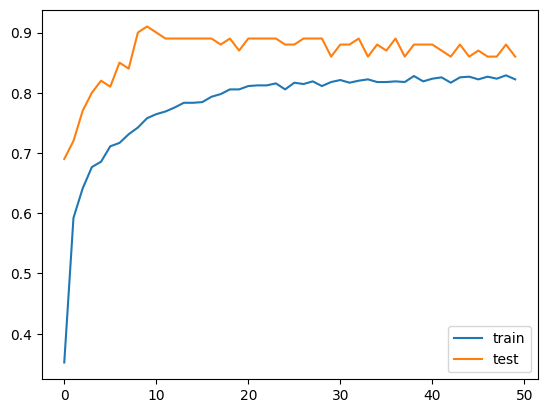

In [13]:
# develop an mlp for blobs dataset
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = int(0.9 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=50, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# learning curves of model accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

The output shows the model's performance on train and test sets - around 83% and 86% accuracy, respectively. Dataset split leads to optimistic bias in test set. Model's accuracy on train and test sets are shown in plot with stable fit.

Train (42, 11) (42, 2) Test (43, 11) (43, 2)
Train: 0.714, Test: 0.791


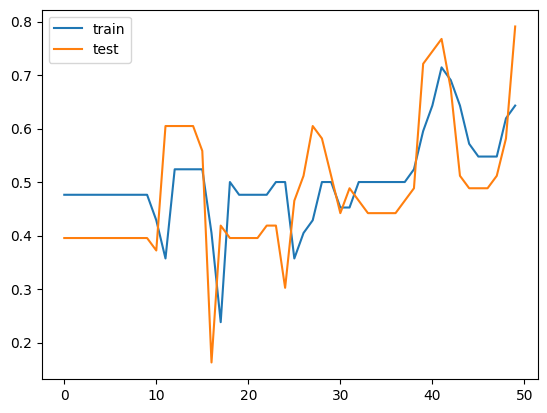

In [27]:
X,y = df_test_classification.loc[:,df_test_classification.columns!= 'chocolate'], df_test_classification['chocolate']
y = to_categorical(y)
X, X_val, y, y_val = train_test_split(X,y, test_size=0.50)
X,y,X_val,y_val = X.values,y,X_val.values,y_val
print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)

# define model
model = Sequential()
model.add(Dense(50, input_dim=X.shape[1], activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(X, y, validation_data=(X_val, y_val), epochs=50, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(X, y, verbose=0)
_, test_acc = model.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# learning curves of model accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

# **Random Splits Ensemble**

Resampling creates new models from fresh training and testing splits to enhance predictability. By averaging and combining models from random splits, we improve estimation, stability, and performance. 10x increase in sample points for improved evaluation. Demo data for display, not for training. We require functions to train, evaluate and get a model for an ensemble using both 5k and 50k examples. The evaluate_model() splits data randomly and fits models on them. Use train_test_split() to divide data and test 10% of 5,000. Assess model and add to lists. Reduce splits, fit 10 models, and evaluate performance. Test 1-10 member groups to find optimal ensemble size for best results. Evaluate models on saved data, compute accuracy scores, compare ensemble size with holdout accuracy. No text provided.

In [58]:
# random-splits mlp ensemble on blobs dataset
# evaluate a single mlp model
def evaluate_model(X_train, y_train, X_test, y_test):
    # encode targets
    y_train_enc = to_categorical(y_train)
    y_test_enc = to_categorical(y_test)
    # define model
    model = Sequential()
    model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(y_train_enc.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit model
    model.fit(X_train, y_train_enc, epochs=50, verbose=0)
    # evaluate the model
    _, test_acc = model.evaluate(X_test, y_test_enc, verbose=0)
    return model, test_acc

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, X_test):
	# make predictions
	yhats = [model.predict(X_test) for model in members]
	yhats = array(yhats)
	# sum across ensemble members
	summed = sum(yhats, axis=0)
	# argmax across classes
	result = argmax(summed, axis=1)
	return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, X_test, y_test):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, X_test)
	# calculate accuracy
	return accuracy_score(y_test, yhat)

# generate 2d classification dataset
dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2, random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]
# multiple train-test splits
n_splits = 10
scores, members = list(), list()
for _ in range(n_splits):
	# split data
	trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.10)
	# evaluate model
	model, test_acc = evaluate_model(trainX, trainy, testX, testy)
	print('>%.3f' % test_acc)
	scores.append(test_acc)
	members.append(model)
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
	ensemble_score = evaluate_n_members(members, i, newX, newy)
	newy_enc = to_categorical(newy)
	_, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

>0.818


KeyboardInterrupt: ignored

10 models tested on 10 splits, averaging 83% accuracy with 1.9% deviation. Ensembles of 1-10 models on another dataset estimated 82% accuracy, but it's likely too high. Accuracy varies among models. Graph shows 1-10 member ensemble performance. 4-to-8 member ensembles more accurate than individual runs, but no superior models identified. Ensembles outperform random models with fewer members, and more repetitions enhance performance steadiness.

Train (85, 11) (85,)
>0.824
>0.735
>0.676
>0.794
>0.882
Estimated Accuracy 0.782 (0.071)
1/1 [==============================] - 0s 50ms/step
> 1: single=0.529, ensemble=0.529
1/1 [==============================] - 0s 54ms/step
> 2: single=0.765, ensemble=0.706
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 52ms/step
> 3: single=0.765, ensemble=0.706
1/1 [==============================] - 0s 50ms/step
> 4: single=0.706, ensemble=0.765
1/1 [==============================] - 0s 66ms/step
> 5: single=0.647, ensemble=0.647
Accuracy 0.682 (0.088)


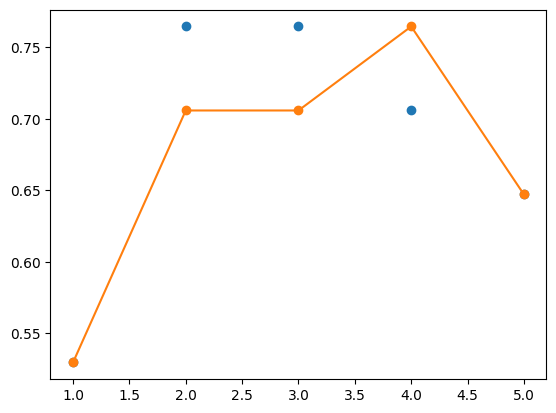

In [61]:
X,y = df_test_classification.loc[:,df_test_classification.columns!= 'chocolate'], df_test_classification['chocolate']
X = X.values
print('Train', X.shape, y.shape)

length = int(len(X)*0.8)
X, newX = X[:length, :], X[length:, :]
y, newy = y[:length], y[length:]

# multiple train-test splits
n_splits = 5
scores, members = list(), list()
for _ in range(n_splits):
	# split data
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50)
	# evaluate model
	model, test_acc = evaluate_model(X_train, y_train, X_test, y_test)
	print('>%.3f' % test_acc)
	scores.append(test_acc)
	members.append(model)
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
	ensemble_score = evaluate_n_members(members, i, newX, newy)
	newy_enc = to_categorical(newy)
	_, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

# **Cross-Validation Ensemble**

Use k-fold cross-validation to reduce bias in performance estimation. Random splits may overestimate, so k parameter groups samples. K=10 reduces bias in Scores. Cross-validation chooses the best neural network models or combines them for better performance. Scikit-learn's KFold provides customizable data splits with shuffling and seed. Indexes generate train and test sets. 10 cross-validated models evaluate ensembles with 1-10 members for accuracy. Avg fold scores indicate model performance.

>0.816
>0.852
>0.854
>0.820
>0.818
>0.816
>0.810
>0.830
>0.816
>0.836
Estimated Accuracy 0.827 (0.015)
1563/1563 [==============================] - 3s 2ms/step
> 1: single=0.820, ensemble=0.820
1563/1563 [==============================] - 2s 1ms/step
> 2: single=0.819, ensemble=0.820
1563/1563 [==============================] - 2s 1ms/step
> 3: single=0.820, ensemble=0.820
1563/1563 [==============================] - 2s 1ms/step
> 4: single=0.819, ensemble=0.820
1563/1563 [==============================] - 3s 2ms/step
> 5: single=0.820, ensemble=0.821
1563/1563 [==============================] - 3s 2ms/step
> 6: single=0.820, ensemble=0.821
1563/1563 [==============================] - 2s 1ms/step
> 7: single=0.820, ensemble=0.821
1563/1563 [==============================] - 2s 1ms/step
> 8: single=0.820, ensemble=0.821
1563/1563 [==============================] - 2s 1ms/step
> 9: single=0.820, ensemble=0.821
1563/1563 [==============================] - 2s 1ms/step
> 10: single=0.820, e

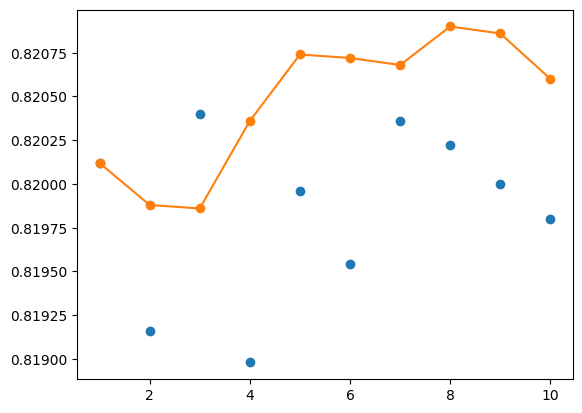

In [62]:
# generate 2d classification dataset
dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2, random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]
# prepare the k-fold cross-validation configuration
n_folds = 10
kfold = KFold(n_folds)
# cross validation estimation of performance
scores, members = list(), list()
for train_ix, test_ix in kfold.split(X):
	# select samples
	trainX, trainy = X[train_ix], y[train_ix]
	testX, testy = X[test_ix], y[test_ix]
	# evaluate model
	model, test_acc = evaluate_model(trainX, trainy, testX, testy)
	print('>%.3f' % test_acc)
	scores.append(test_acc)
	members.append(model)
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, n_folds+1):
	ensemble_score = evaluate_n_members(members, i, newX, newy)
	newy_enc = to_categorical(newy)
	_, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
x_axis = [i for i in range(1, n_folds+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

Model performance shown for each fold in cross-validation, averaging 82%, less optimistic than random-splits. Saved models evaluated on holdout set with 82% average score. Graph compares model accuracy and ensemble size, with similar performance. More members improve accuracy, but there's a point of diminishing returns. Using four or more models in an ensemble is better. All models' default strategy is effective.

Train (1000, 11) (1000,)
>0.925
>0.938
>0.950
>0.887
>0.887
>0.887
>0.875
>0.837
>0.913
>0.950
Estimated Accuracy 0.905 (0.035)
7/7 [==============================] - 0s 3ms/step
> 1: single=0.915, ensemble=0.915
7/7 [==============================] - 0s 2ms/step
> 2: single=0.915, ensemble=0.915
7/7 [==============================] - 0s 2ms/step
> 3: single=0.890, ensemble=0.915
7/7 [==============================] - 0s 2ms/step
> 4: single=0.890, ensemble=0.915
7/7 [==============================] - 0s 2ms/step
> 5: single=0.870, ensemble=0.890
7/7 [==============================] - 0s 2ms/step
> 6: single=0.875, ensemble=0.890
7/7 [==============================] - 0s 2ms/step
> 7: single=0.915, ensemble=0.890
7/7 [==============================] - 0s 2ms/step
> 8: single=0.890, ensemble=0.890
7/7 [==============================] - 0s 2ms/step
> 9: single=0.880, ensemble=0.890
7/7 [==============================] - 0s 2ms/step
> 10: single=0.875, ensemble=0.890
Accuracy 0.892 (0.017

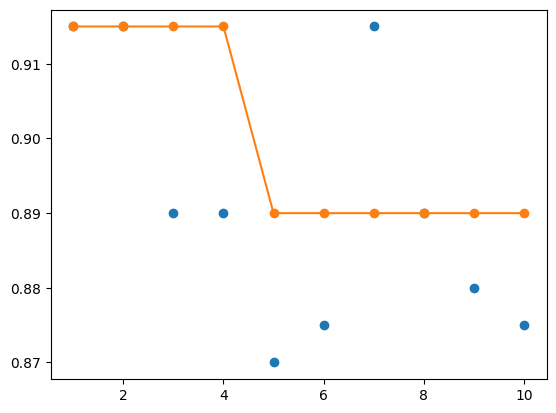

In [66]:
df_test_resampled = df_test_classification.sample(1000,replace=True).reset_index(drop=True)
X,y = df_test_resampled.loc[:,df_test_resampled.columns!= 'chocolate'], df_test_resampled['chocolate']
X = X.values
print('Train', X.shape, y.shape)

length = int(len(X)*0.8)
X, newX = X[:length, :], X[length:, :]
y, newy = y[:length], y[length:]

# multiple train-test splits
n_splits = 10
kfold = KFold(n_folds)
# cross validation estimation of performance
scores, members = list(), list()
for train_ix, test_ix in kfold.split(X):
	# select samples
	trainX, trainy = X[train_ix], y[train_ix]
	testX, testy = X[test_ix], y[test_ix]
	# evaluate model
	model, test_acc = evaluate_model(trainX, trainy, testX, testy)
	print('>%.3f' % test_acc)
	scores.append(test_acc)
	members.append(model)
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, n_folds+1):
	ensemble_score = evaluate_n_members(members, i, newX, newy)
	newy_enc = to_categorical(newy)
	_, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
x_axis = [i for i in range(1, n_folds+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

# **Bagging Ensemble**
Bootstrap method improves ensemble learning by using small data samples and repeated inclusion and sampling with replacement to estimate neural network model performance. Ensemble learning equals k-fold cross-validation with bias sampling. Bagging with resample() is a preferred bootstrap method. Get 4.5k data by selecting X and y rows, use bagging with unpruned trees. Keep MLP despite overfit NNs, limit reached with 10. Bootstrap MLP ensemble.

>0.823
>0.818
>0.820
>0.830
>0.821
>0.824
>0.845
>0.822
>0.829
>0.827
Estimated Accuracy 0.826 (0.007)
1563/1563 [==============================] - 3s 2ms/step
> 1: single=0.820, ensemble=0.820
1563/1563 [==============================] - 2s 1ms/step
> 2: single=0.819, ensemble=0.820
1563/1563 [==============================] - 3s 2ms/step
> 3: single=0.818, ensemble=0.821
1563/1563 [==============================] - 2s 1ms/step
> 4: single=0.819, ensemble=0.820
1563/1563 [==============================] - 2s 1ms/step
> 5: single=0.819, ensemble=0.820
1563/1563 [==============================] - 2s 1ms/step
> 6: single=0.820, ensemble=0.820
1563/1563 [==============================] - 3s 2ms/step
> 7: single=0.820, ensemble=0.820
1563/1563 [==============================] - 2s 1ms/step
> 8: single=0.817, ensemble=0.821
1563/1563 [==============================] - 2s 1ms/step
> 9: single=0.820, ensemble=0.820
1563/1563 [==============================] - 2s 1ms/step
> 10: single=0.820, e

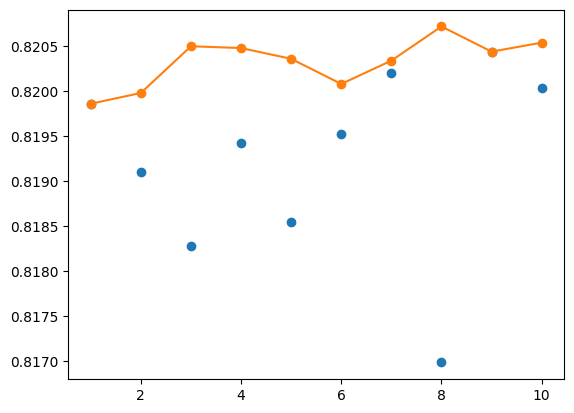

In [67]:
# generate 2d classification dataset
dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2, random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]
# multiple train-test splits
n_splits = 10
scores, members = list(), list()
for _ in range(n_splits):
	# select indexes
	ix = [i for i in range(len(X))]
	train_ix = resample(ix, replace=True, n_samples=4500)
	test_ix = [x for x in ix if x not in train_ix]
	# select data
	trainX, trainy = X[train_ix], y[train_ix]
	testX, testy = X[test_ix], y[test_ix]
	# evaluate model
	model, test_acc = evaluate_model(trainX, trainy, testX, testy)
	print('>%.3f' % test_acc)
	scores.append(test_acc)
	members.append(model)
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
	ensemble_score = evaluate_n_members(members, i, newX, newy)
	newy_enc = to_categorical(newy)
	_, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

Model's unused performance displayed during run. Similar to k-fold cross-validation, less optimistic than random splits. Bootstrap sampling worsens performance on large datasets. Bagged ensembles perform better than individual models with 4+ members.

Train (10000, 11) (10000,)
>0.941
>0.957
>0.990
>0.940
>0.952
>0.951
>0.924
>0.976
>0.957
>0.989
Estimated Accuracy 0.958 (0.021)
63/63 [==============================] - 0s 2ms/step
> 1: single=0.939, ensemble=0.939
63/63 [==============================] - 0s 1ms/step
> 2: single=0.947, ensemble=0.959
63/63 [==============================] - 0s 2ms/step
> 3: single=0.989, ensemble=0.959
63/63 [==============================] - 0s 2ms/step
> 4: single=0.934, ensemble=0.959
63/63 [==============================] - 0s 1ms/step
> 5: single=0.947, ensemble=0.959
63/63 [==============================] - 0s 2ms/step
> 6: single=0.947, ensemble=0.959
63/63 [==============================] - 0s 2ms/step
> 7: single=0.915, ensemble=0.959
63/63 [==============================] - 0s 2ms/step
> 8: single=0.974, ensemble=0.959
63/63 [==============================] - 0s 1ms/step
> 9: single=0.947, ensemble=0.959
63/63 [==============================] - 0s 2ms/step
> 10: single=0.989, ensemble=0.959

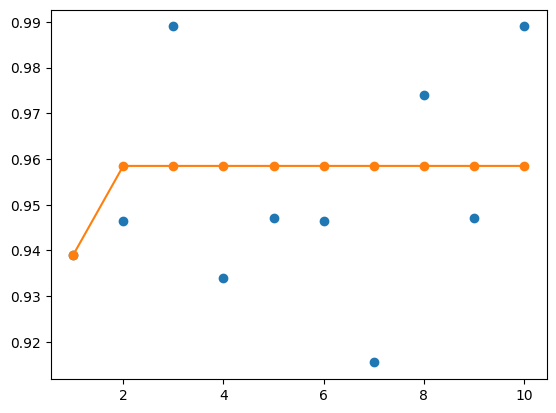

In [69]:
df_test_resampled = df_test_classification.sample(10000,replace=True).reset_index(drop=True)
X,y = df_test_resampled.loc[:,df_test_resampled.columns!= 'chocolate'], df_test_resampled['chocolate']
X = X.values
print('Train', X.shape, y.shape)

length = int(len(X)*0.8)
X, newX = X[:length, :], X[length:, :]
y, newy = y[:length], y[length:]

# multiple train-test splits
n_splits = 10
scores, members = list(), list()
for _ in range(n_splits):
	# select indexes
	ix = [i for i in range(len(X))]
	train_ix = resample(ix, replace=True, n_samples=4500)
	test_ix = [x for x in ix if x not in train_ix]
	# select data
	trainX, trainy = X[train_ix], y[train_ix]
	testX, testy = X[test_ix], y[test_ix]
	# evaluate model
	model, test_acc = evaluate_model(trainX, trainy, testX, testy)
	print('>%.3f' % test_acc)
	scores.append(test_acc)
	members.append(model)
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
	ensemble_score = evaluate_n_members(members, i, newX, newy)
	newy_enc = to_categorical(newy)
	_, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

# **Extensions**

Compare ensemble performance to single model. Try different ensemble sizes for cross-validation and compare results. Increase bagging ensemble size to find diminishing returns.

# **Summary**

We created resampling-based ensembles for neural networks by estimating performance with random-splits and cross-validation. Bootstrap for estimation and bagging.

# **Stacking Ensemble for Deep Learning Neural Networks**

Model averaging combines sub-models and can be enhanced with weighted sub-models. Stacking trains a new model for improved predictions. Learn stacked generalization ensemble for deep learning using submodels and meta-learner.

# **Tutorial Overview**

- Stacked Generalization Ensemble

- Multi-Class Classification Problem

- Multilayer Perceptron Model

- Train and Save Sub-Models

- Separate Stacking Model

- Integrated Stacking Model

# **Stacked Generalization Ensemble**
To optimize contributions, trust and performance on holdout set are key. Weighted ensemble outperforms model average. Use sub-model stacking in 2-level linear regression to enhance output predictions during training. Lvl 1: Meta-learner predicts. Stacked generalization reduces biases & stacked ensemble improves performance. Improve generalizer, use diverse dataset to train and split into train/validation. Train level 0 models and use for k-fold cross-validation when training level 1 model with predictions. Train meta-learner with diverse algorithms using untrained model predictions. Exclude same-type models in stacking. Blend predictions using regression, ensemble methods, and class probabilities. Also, create a deep learning model for improved accuracy.

# **Multi-Class Classification Problem**

We'll use make_blobs() function from scikit-learn to demonstrate stacking ensembles for a small multi-class classification problem. Two input variables, std dev of 2.0, consistent data points with same random state. Modellable results. Plot points, color by class.

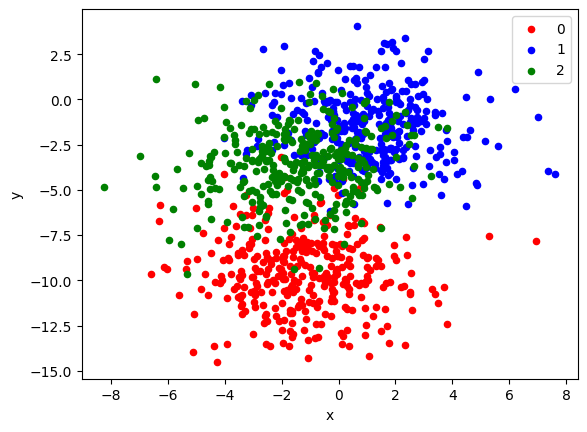

In [70]:
# scatter plot of blobs dataset
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

This scatter plot has non-linearly separable classes with ambiguous points due to a standard deviation of 2.0, which is ideal for neural networks to find diverse solutions resulting in high variance.

# **Multilayer Perceptron Model**

Using limited data, our stacking ensemble model will train on 100 points and test on 1,000. We will generate 1,100 points for the blobs problem and predict probabilities for three classes with softmax activation and to_categorical encoding. Create a model with 2 inputs, 1 hidden layer (25 nodes), and 1 output layer (3 nodes) using rectified linear and softmax activation, and optimize with categorical cross-entropy loss and Adam variant of SGD for training and testing. Train 500 epochs, evaluate on train and test sets. 

(100, 2) (1000, 2)
Train: 0.840, Test: 0.806


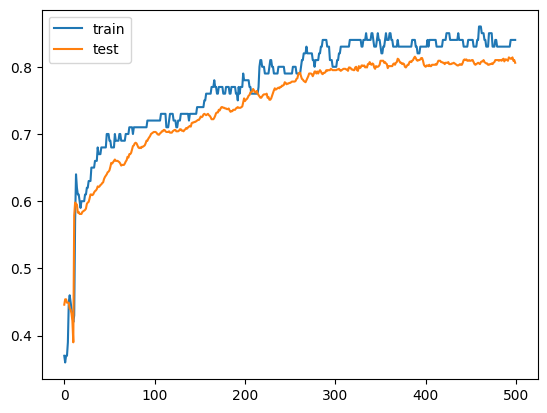

In [71]:
# develop an mlp for blobs dataset
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# learning curves of model accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

The model's training accuracy was 85% and testing accuracy was 80%, as anticipated. A line plot shows model accuracy on train and test sets during training, with training accuracy being more optimistic. Use model in stacking ensemble.

Train (10000, 11) (10000, 2)
(8000, 11) (2000, 11)
Train: 1.000, Test: 1.000


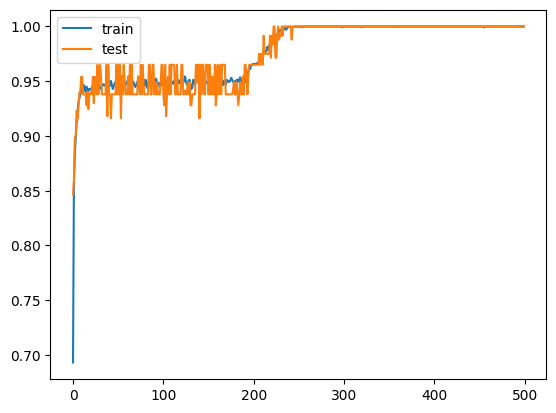

In [78]:
df_test_resampled = df_test_classification.sample(10000,replace=True).reset_index(drop=True)
X,y = df_test_resampled.loc[:,df_test_resampled.columns!= 'chocolate'], df_test_resampled['chocolate']
X = X.values
y = to_categorical(y)
print('Train', X.shape, y.shape)

length = int(len(X)*0.8)
X, newX = X[:length, :], X[length:, :]
y, newy = y[:length], y[length:]

print(X.shape, newX.shape)
# define model
model = Sequential()
model.add(Dense(25, input_dim=X.shape[1], activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(X, y, validation_data=(newX, newy), epochs=500, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(X, y, verbose=0)
_, test_acc = model.evaluate(newX, newy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# learning curves of model accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

# **Train and Save Sub-Models**

Use sub-models and validation set to train meta-learner in stacking ensemble with k-fold cross-validation and different MLP models. Save sub-models for stacking ensembles. Define and fit an MLP model using training data. Make a models sub-directory, deleting if needed for re-runs. Create and save multiple MLP instances to "models/" with unique filenames. Test performance with 5 sub-models. Training and saving example below.

In [82]:
# example of saving sub-models for later use in a stacking ensemble
# fit model on dataset
def fit_model(X_train, y_train):
	# define model
	model = Sequential()
	model.add(Dense(25, input_dim=X_train.shape[1], activation='relu'))
	model.add(Dense(y_train.shape[1], activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(X_train, y_train, epochs=500, verbose=0)
	return model

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# create directory for models
makedirs('models')
# fit and save models
n_members = 5
for i in range(n_members):
	# fit model
	model = fit_model(trainX, trainy)
	# save model
	filename = 'models/model_' + str(i + 1) + '.h5'
	model.save(filename)
	print('>Saved %s' % filename)

(100, 2) (1000, 2)
>Saved models/model_1.h5
>Saved models/model_2.h5
>Saved models/model_3.h5
>Saved models/model_4.h5
>Saved models/model_5.h5


Training creates "models/" subfolder and 5 unique models. Train meta-learner with predictions.

In [83]:
df_test_resampled = df_test_classification.sample(10000,replace=True).reset_index(drop=True)
X,y = df_test_resampled.loc[:,df_test_resampled.columns!= 'chocolate'], df_test_resampled['chocolate']
X = X.values
y = to_categorical(y)
print('Train', X.shape, y.shape)

# split into train and test
n_train = 1000
# create directory for models
makedirs('models_realdata')
# fit and save models
n_members = 5
for i in range(n_members):
	# fit model
	model = fit_model(X, y)
	# save model
	filename = 'models/models_realdata' + str(i + 1) + '.h5'
	model.save(filename)
	print('>Saved %s' % filename)

Train (10000, 11) (10000, 2)
(10000, 11) (2000, 11)
>Saved models/models_realdata1.h5
>Saved models/models_realdata2.h5
>Saved models/models_realdata3.h5
>Saved models/models_realdata4.h5
>Saved models/models_realdata5.h5


# **Separate Stacking Model**

Train. Load models. Load and evaluate 5 saved models with "load_model()" and compare their performance to the stacking model. Evaluate each model on training data, train meta-learner with a dataset, and test submodels make 3 predictions/sample for 3 categories to establish baseline performance. Stack 1000 test samples with dstack() and fit into a new model using 15 features per example from 5 models with 3 predictions each. Reshape predictions to [1000, 15] using NumPy's Reshape() for meta-learner training via stacked_dataset(). Train a meta-learner with scikit-learn's logistic regression model using input and test set output. Build the logistic regression model using fit_stacked_model() on loaded models and training data. Use stacked models and meta-learner with stacked_prediction() to predict new data, including an example of linear meta-learner fitting.

In [84]:
# stacked generalization with linear meta model on blobs dataset
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression()
	model.fit(stackedX, inputy)
	return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# evaluate standalone models on test dataset
for model in members:
	testy_enc = to_categorical(testy)
	_, acc = model.evaluate(testX, testy_enc, verbose=0)
	print('Model Accuracy: %.3f' % acc)
# fit stacked model using the ensemble
model = fit_stacked_model(members, testX, testy)
# evaluate model on test set
yhat = stacked_prediction(members, model, testX)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

(100, 2) (1000, 2)
>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
Loaded 5 models
Model Accuracy: 0.815
Model Accuracy: 0.805
Model Accuracy: 0.814
Model Accuracy: 0.818
Model Accuracy: 0.795
Stacked Test Accuracy: 0.829


After loading and evaluating sub-models, the final model achieves 81.3% accuracy. A logistic regression meta-learner is then trained and evaluated, surpassing sub-models with 82.4% accuracy.

# **Integrated Stacking Model**

Streamline output with neural submodels and adjust weights using Keras. Develop stacked ensemble with fixed input heads, rename layers, and merge sub-model inputs towards 15-vector output. Train stacked model graph, update layer weights with test data. Predict using model & k submodels after 300 epochs. Use predict_stacked_model() for more accurate predictions than submodels, similar to linear meta-learner. N/A cannot be shortened further.

In [95]:
# stacked generalization with neural net meta model on blobs dataset
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

# define stacked model from multiple member input models
def define_stacked_model(members):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(10, activation='relu')(merge)
	output = Dense(3, activation='softmax')(hidden)
	model = Model(inputs=ensemble_visible, outputs=output)
	# plot graph of ensemble
	plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# encode output data
	inputy_enc = to_categorical(inputy)
	# fit model
	model.fit(X, inputy_enc, epochs=300, verbose=0)

# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X, verbose=0)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# define ensemble model
stacked_model = define_stacked_model(members)
# fit stacked model on test dataset
fit_stacked_model(stacked_model, testX, testy)
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, testX)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

(100, 2) (1000, 2)
>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
Loaded 5 models
Stacked Test Accuracy: 0.836


A bigger neural network ensemble is trained on the test dataset and achieves an accuracy of 83.3%, out-performing the previous linear model.

# **Extensions**

Test new meta-learner classifier and compare with one level-0 model. Analyze accuracy correlation of sub-models in stacked ensemble with k-fold cross-validation on
Ensemble's meta-learner training set. Raw Input vs Sub-Models in Meta-Learner.

# **Summary**

We found a way to create stacked generalization ensembles for neural networks, which involves combining predictions from multiple models. Develop a stacking model using neural networks and scikit-learn classifiers as the meta-learner.